https://www.tensorflow.org/guide/data, well down the page

In [ ]:
import tensorflow as tf

In [2]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

In [3]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

30874/30874 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

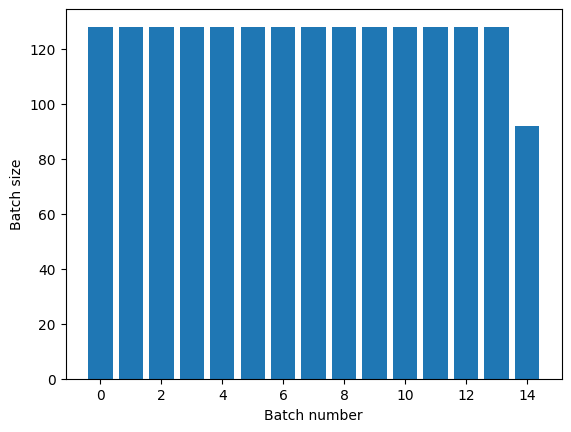

In [5]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

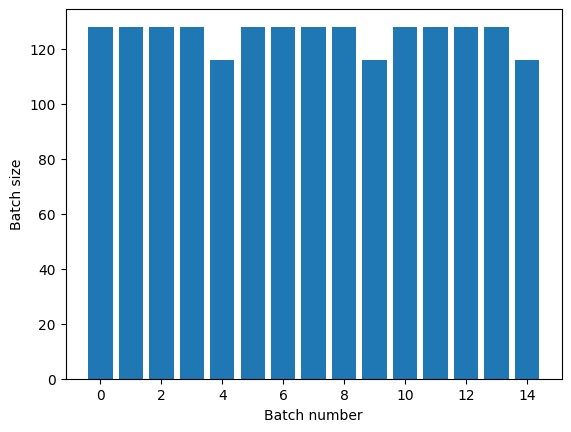

In [6]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

In [7]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


In [8]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [9]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 82   2  28  23  29  59 105  14  60  63  16  53  69  89 112  22  94  66
  40  80]


In [10]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[551 327 545 612 624 604 593 506 559 519]
[579 503 588 453 568 156 617 625 608 600]
[512 572 597 242 614 494 627 158]
[ 1 96 79 48 50  2 47 32 24 38]
[ 7 30  9 66 34 33  0 98 89 71]


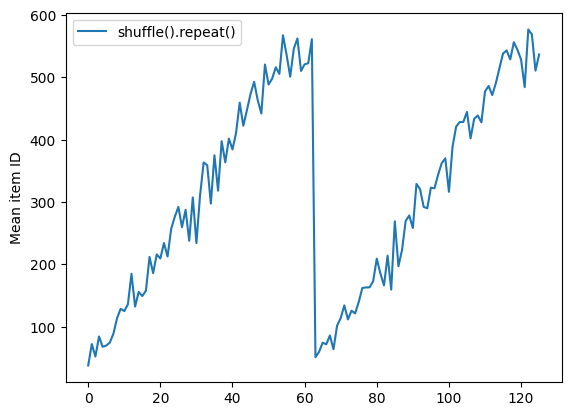

In [11]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

In [12]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[414 470   1 289 413 393 608 617 615  24]
[551  22 247 604   4  36 461  28 595   0]
[600 491 618 592  11 516  41 579 324 583]
[ 45 398 620 627  30  18 505 532  20  12]
[ 37 586 430  39  64  46 606 523  27 587]
[626 594  43 314  59   7 601  17 585 557]
[ 32  72  65  15  53  26 607 554 567 447]
[476 495  55  42  95  75  60  81  67 322]
[ 62   9  48 614  92 510  70 530  44  54]
[511 463 102  57  74  14 108  80 100  51]
[584 546   5 515 609 622 499  97 110 130]
[555  90 124 123 115 107 372  91 611  35]
[ 68 625  47  87 126 597 518 133 120 121]
[145   3  82 149   6 154  79 153 541 103]
[ 49  84 119 576  21 125  93 164 512 118]


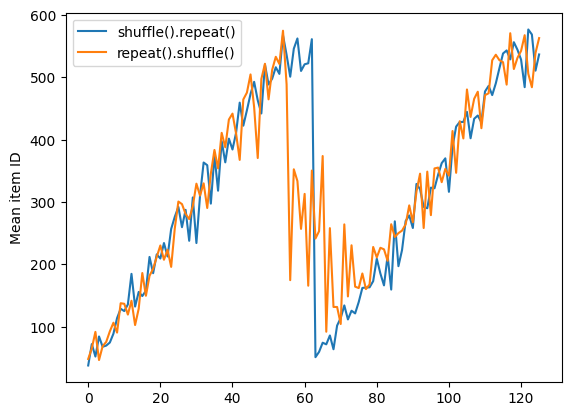

In [13]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

In [15]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [16]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

In [17]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

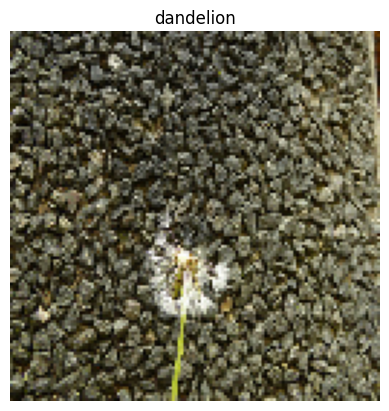

In [18]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

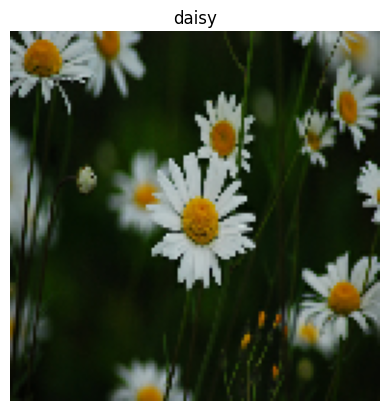

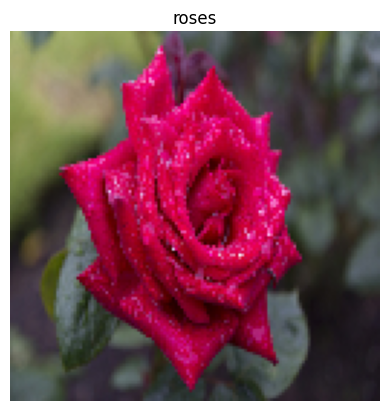

In [19]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

In [20]:
import scipy.ndimage as ndimage

@tf.py_function(Tout=tf.float32)
def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

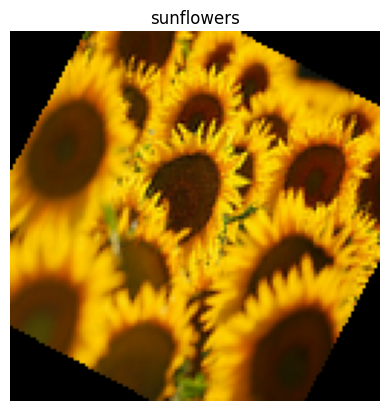

In [21]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)